## Importing File

In [1]:
import pandas as pd
import numpy as np
path = 'data/df5.csv'
df = pd.read_csv(path)

In [2]:
cfw_outlet_temp=[i for i in df.columns if i.endswith('CFW_OUTLET_TEMP')]
exh_gas_outlet_temp=[i for i in df.columns if i.endswith('EXH_GAS_OUTLET_TEMP')]
df['ME1_CYL_CFW_OUTLET_TEMP']=df[cfw_outlet_temp].apply(np.mean,axis=1)
df['ME1_CYL_EXH_GAS_OUTLET_TEMP']=df[cfw_outlet_temp].apply(np.mean,axis=1)
df=df.drop(cfw_outlet_temp,axis='columns')
df=df.drop(exh_gas_outlet_temp,axis='columns')
df=(df - df.mean())/df.std()

## Making First Ensemble Set

In [3]:
!pip install pyod

In [4]:
# Importing possible approaches
from pyod.models.lof import LOF

In [39]:
from pyod.models.lscp import LSCP
from pyod.models.knn import KNN
detectorList={}
k = np.arange(5,150,15)
for i in k:
    detectorList[i] = LOF(n_neighbors=i)
for i in detectorList:
    detectorList[i].fit(df)



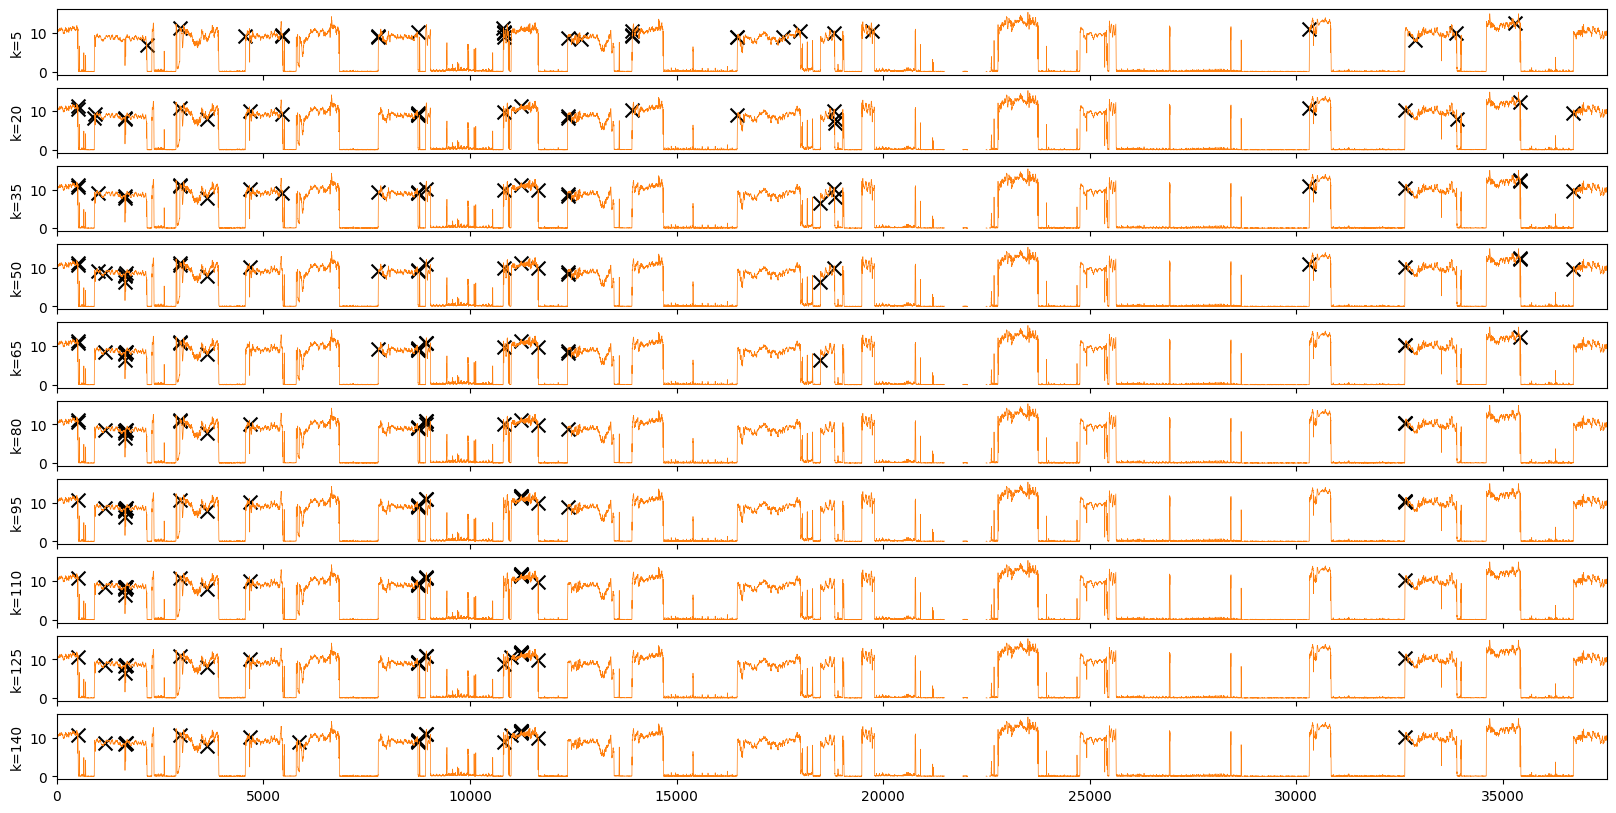

In [40]:
df_index=pd.read_csv('data/df4.csv',index_col=0)
raw=pd.read_csv('data/V7XJ9_10min.csv')
f, axes = plt.subplots(10, 1, figsize=(20, 10), sharex=True)
axcount=0
for i in detectorList:
    anomalyScore=detectorList[i].decision_scores_
    q=np.quantile(anomalyScore,0.998)
    outlierIndex=np.where(anomalyScore>q)[0]
    tempIndex=df_index.iloc[outlierIndex].index
    axes[axcount].grid(False)
    axes[axcount].plot(range(len(raw)), raw['SPEED_VG'], c='C1', linewidth=0.5)
    axes[axcount].set_ylabel(f'k={i}')
    axes[axcount].set_xlim(0,len(raw))
    for p in tempIndex:
        axes[axcount].scatter(p,raw.loc[p]['SPEED_VG'],marker='x', s=100, color='black')
        
    axcount += 1

## Anomaly Score Analysis

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
mpl.style.use('default')

## Clustering

In [393]:
k=4
X=df.loc[outlierIndex].copy()
X['cluster']=cluster[k].predict(X)
n=df.loc[[i for i in df.index if i not in outlierIndex]]
n['cluster']=k
new=pd.concat([X,n],axis=0)

In [342]:
raw=pd.read_csv('data/V7XJ9_10min.csv')
df_index=pd.read_csv('data/df4.csv',index_col=0)

In [343]:
outlierInfo=raw.iloc[df_index.iloc[outlierIndex].index][['TIME_STAMP','LAT','LON']]
outlierInfo['cluster']=cluster[k].labels_

In [344]:
outlierColor=['C'+str(i) for i in outlierInfo['cluster']]
outlierSize=clf.decision_scores_[outlierIndex]*10

In [345]:
markerDict=dict(zip(range(6),['^','v','o','x',',','+']))
outlierMarker=[markerDict[i] for i in outlierInfo['cluster']]

<Figure size 15000x500 with 0 Axes>

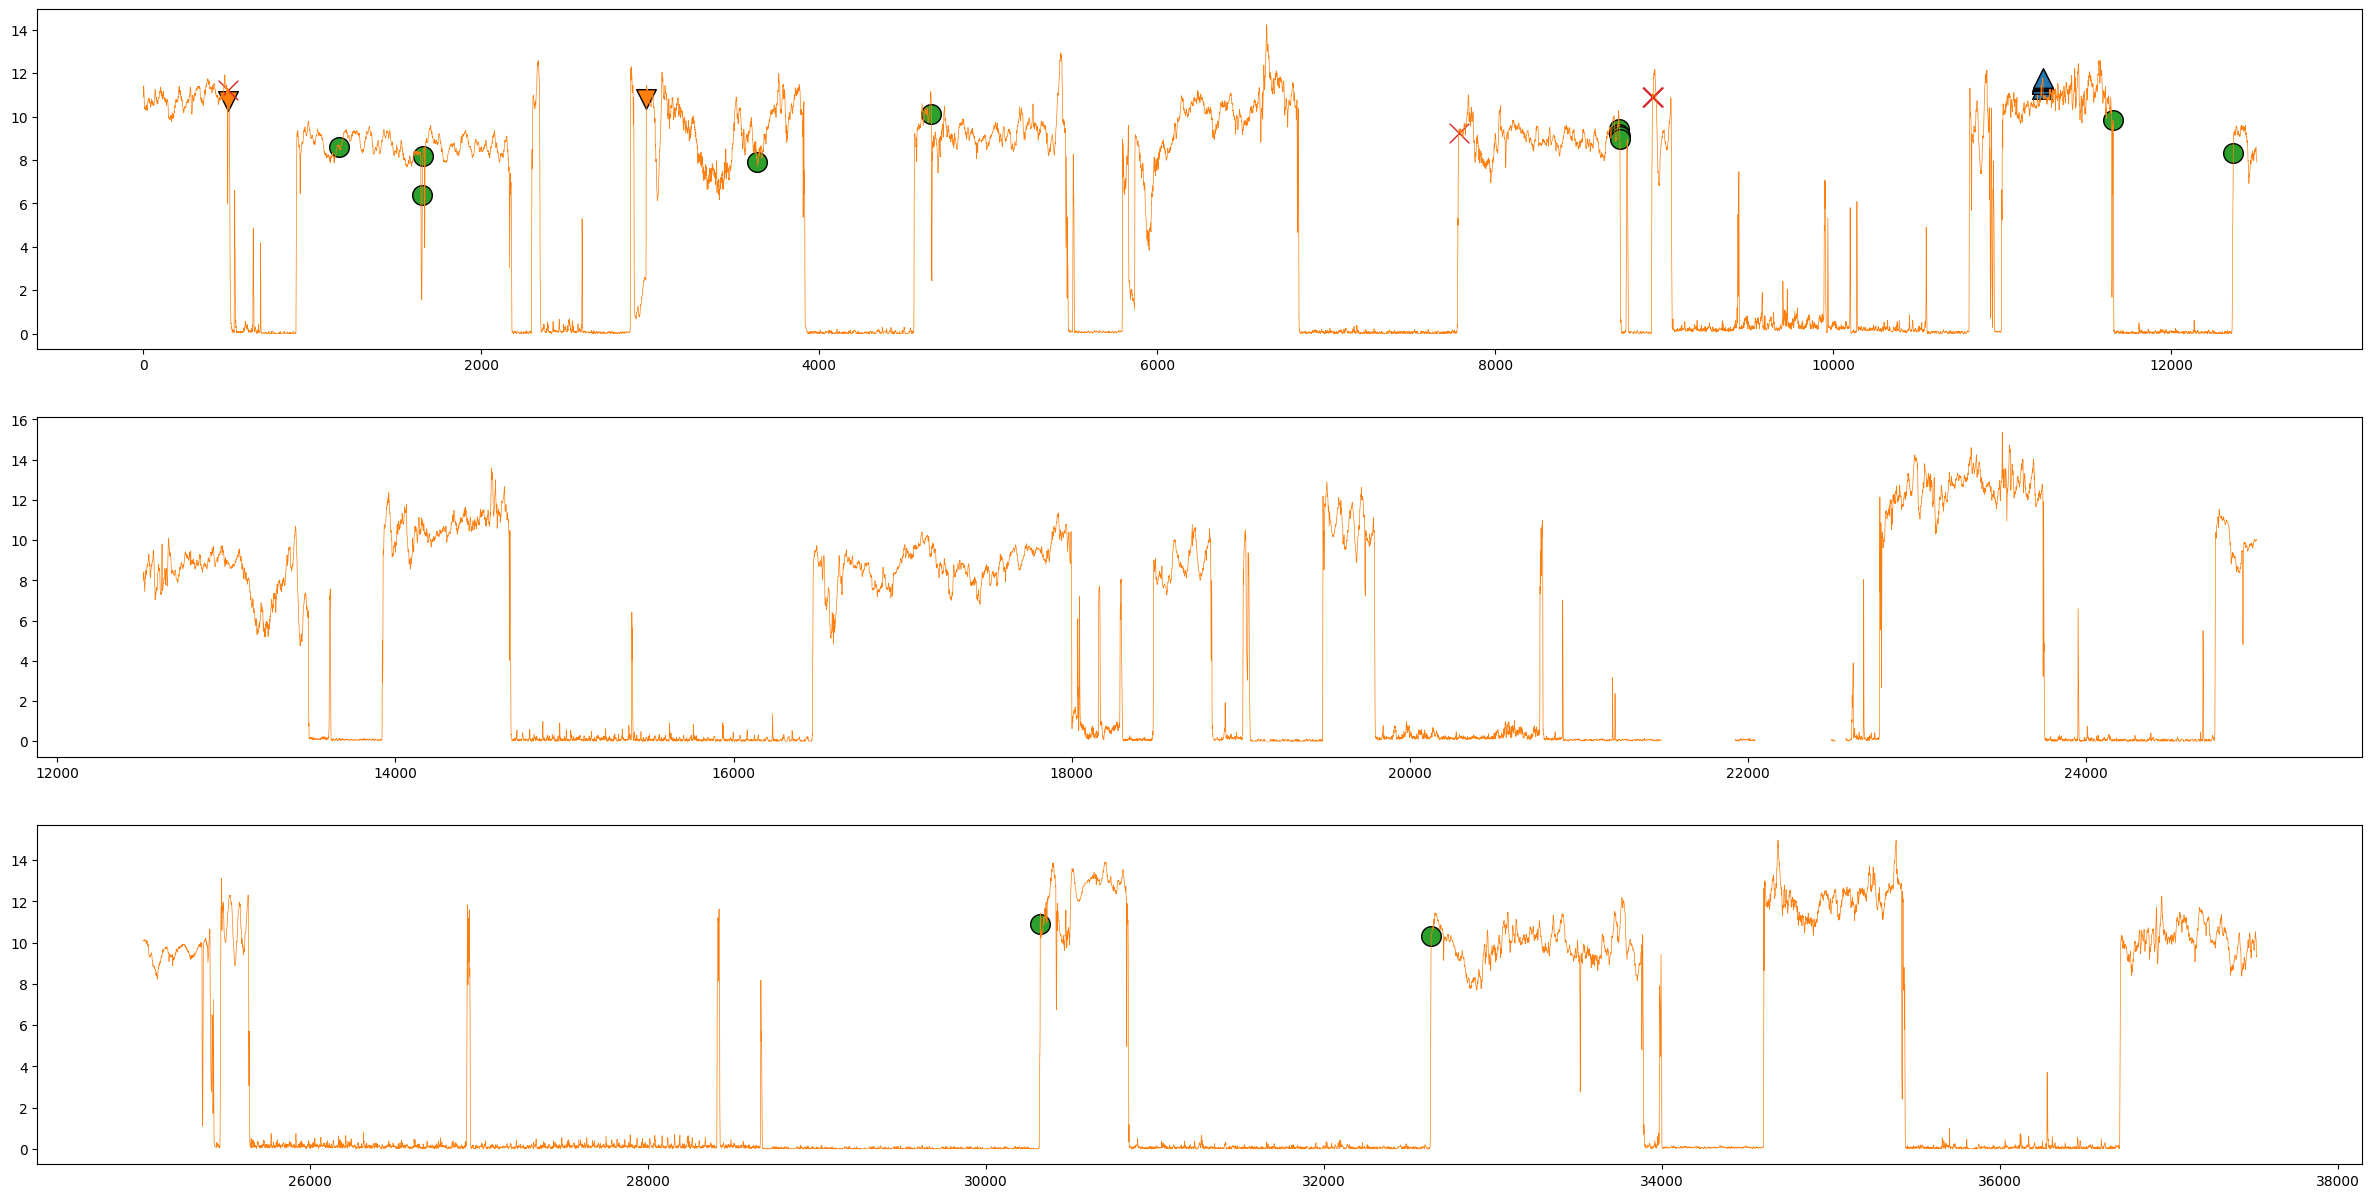

In [394]:
import matplotlib.pyplot as plt
plt.figure(figsize=(150,5))
f, axes = plt.subplots(3, 1, figsize=(30, 15))
batch_size=int(len(raw)/3)
axcount=0
for i in range(0,len(raw)-batch_size,batch_size):
    axes[axcount].grid(False)
    axes[axcount].plot(range(i,i+batch_size),raw.iloc[i:i+batch_size]['SPEED_VG'],c='C1',linewidth=0.5)
#     ax2=axes[axcount].twinx()
#     ax2.grid(False)
#     ax2.set_ylim([50,100])
#     ax2.plot(range(i,i+batch_size),raw.iloc[i:i+batch_size]['ME1_RPM'],c='grey',linewidth=0.5)
    tempIndex=outlierInfo.index
    temp_idx=tempIndex[(tempIndex<i+batch_size) & (tempIndex>=i)]
    temp_c=np.array(outlierColor)[(tempIndex<i+batch_size) & (tempIndex>=i)]
    temp_s=np.array(outlierSize)[(tempIndex<i+batch_size) & (tempIndex>=i)]
    temp_m=np.array(outlierMarker)[(tempIndex<i+batch_size) & (tempIndex>=i)]
    for i,m in zip(temp_idx,range(len(temp_idx))):       
        axes[axcount].scatter(i,raw.loc[i]['SPEED_VG'],c=temp_c[m],s=200,marker=temp_m[m],edgecolors='black',linewidth=1)
        
    #axes[axcount].scatter(temp_idx,raw.loc[temp_idx]['SPEED_VG'],c=temp_c,s=temp_s)
    axcount += 1

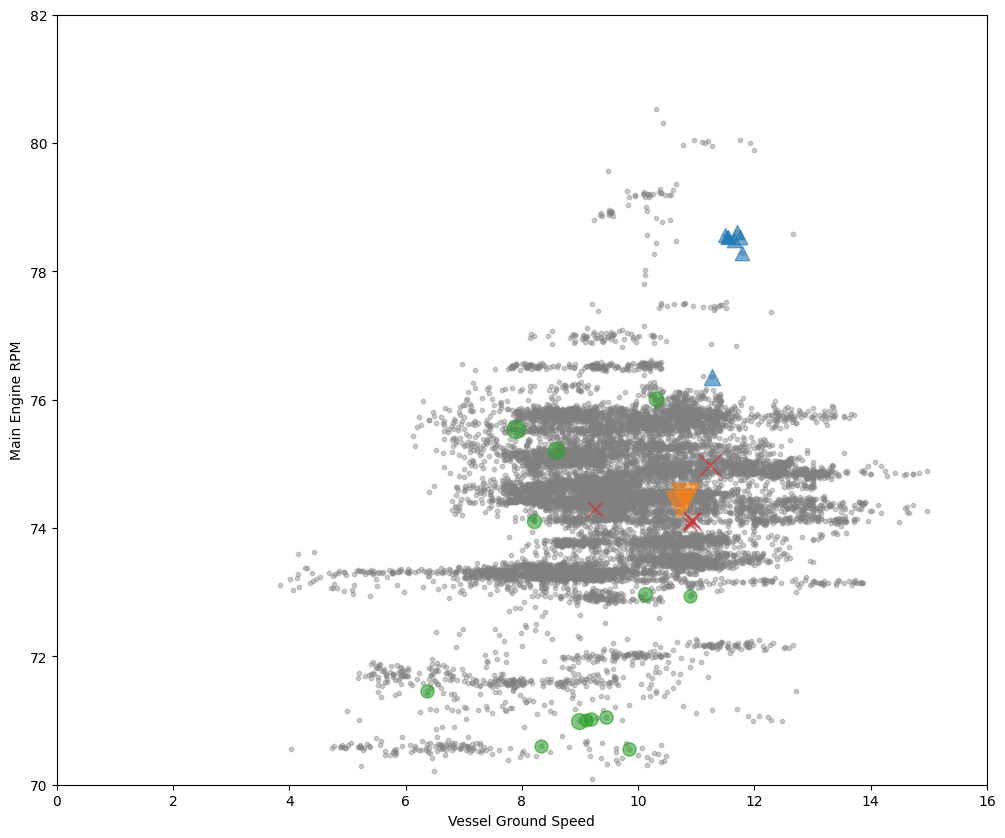

In [395]:
outlierInfo.index
plt.figure(figsize=(12,10))
plt.scatter(raw['SPEED_VG'],raw['ME1_RPM'],color='grey',s=10,alpha=0.4)
plt.ylim([70,82])
plt.xlim([0,16])
plt.xlabel('Vessel Ground Speed')
plt.ylabel('Main Engine RPM')
for o,i in zip(outlierInfo.index, range(len(outlierInfo.index))):
    x=raw.iloc[o]['SPEED_VG']
    y=raw.iloc[o]['ME1_RPM']
    plt.scatter(x,y,c=outlierColor[i],s=outlierSize[i],marker=outlierMarker[i],alpha=0.6)


In [139]:
# https://stackoverflow.com/questions/54613992/how-to-install-and-use-basemap-on-google-colab
# !apt-get install libgeos-3.5.0
# !apt-get install libgeos-dev
# !pip install https://github.com/matplotlib/basemap/archive/master.zip
# !pip install pyproj==1.9.6
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline

In [349]:
margin=10

lat=raw.iloc[df_index.index]['LAT'].values
lon=raw.iloc[df_index.index]['LON'].values

olat=outlierInfo['LAT'].values
olon=outlierInfo['LON'].values

lllat=lat.min()-margin
lllon=lon.min()-margin
urlat=lat.max()+margin
urlon=lon.max()+margin

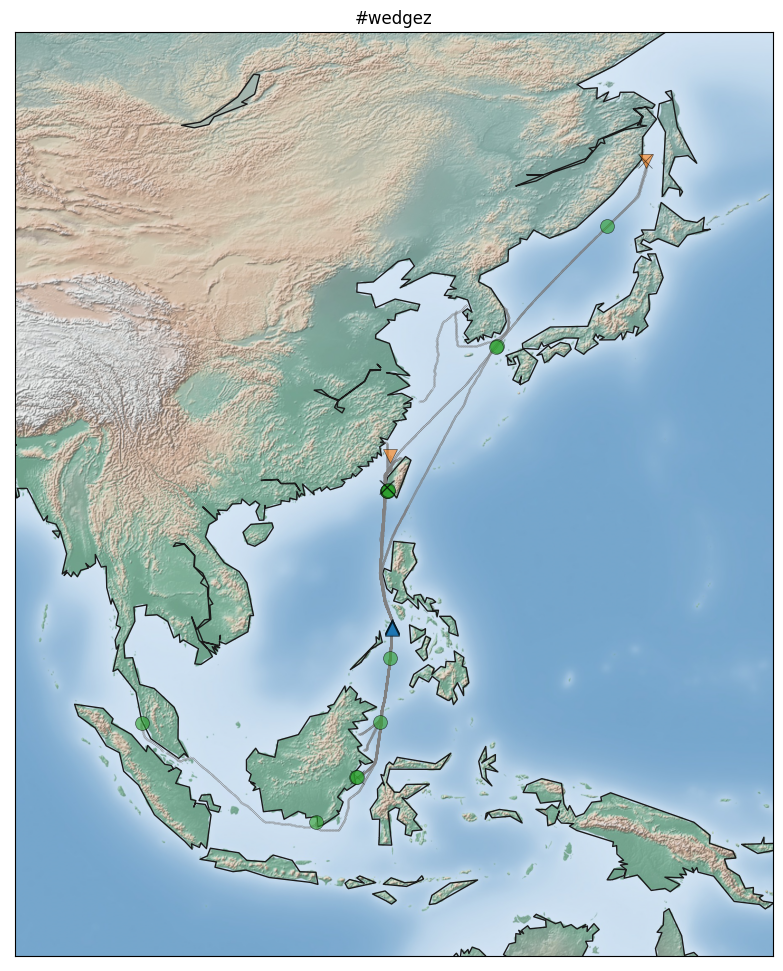

In [406]:
fig = plt.figure(figsize=(12, 12))
m = Basemap(projection='cyl', resolution='c',
            llcrnrlon=lllon,llcrnrlat=lllat,urcrnrlon=urlon,urcrnrlat=urlat)


x,y = m(lon, lat)
m.shadedrelief()
# m.bluemarble()
# m.fillcontinents(color="#FFDDCC", lake_color='#DDEEFF')
# m.drawmapboundary(fill_color="#DDEEFF")
m.drawcoastlines()
m.plot(x, y, 'o', markersize=0.1, c='grey')
x,y = m(olon,olat)

# m.plot(x, y, '+', markersize=result['aomScore'][outlierIndex], c='red')
for x1,y1,oc,os,om in zip(olon,olat,outlierColor,np.log(outlierSize)*2,outlierMarker):
    m.plot(x1, y1, color=oc, marker=om, markersize=10, mew=0.5, mec='black', alpha=0.6)
plt.title("#wedgez")
plt.show()  

In [120]:
from sklearn.manifold import t_sne,TSNE
X_embedded = TSNE(n_components=2).fit_transform(df)

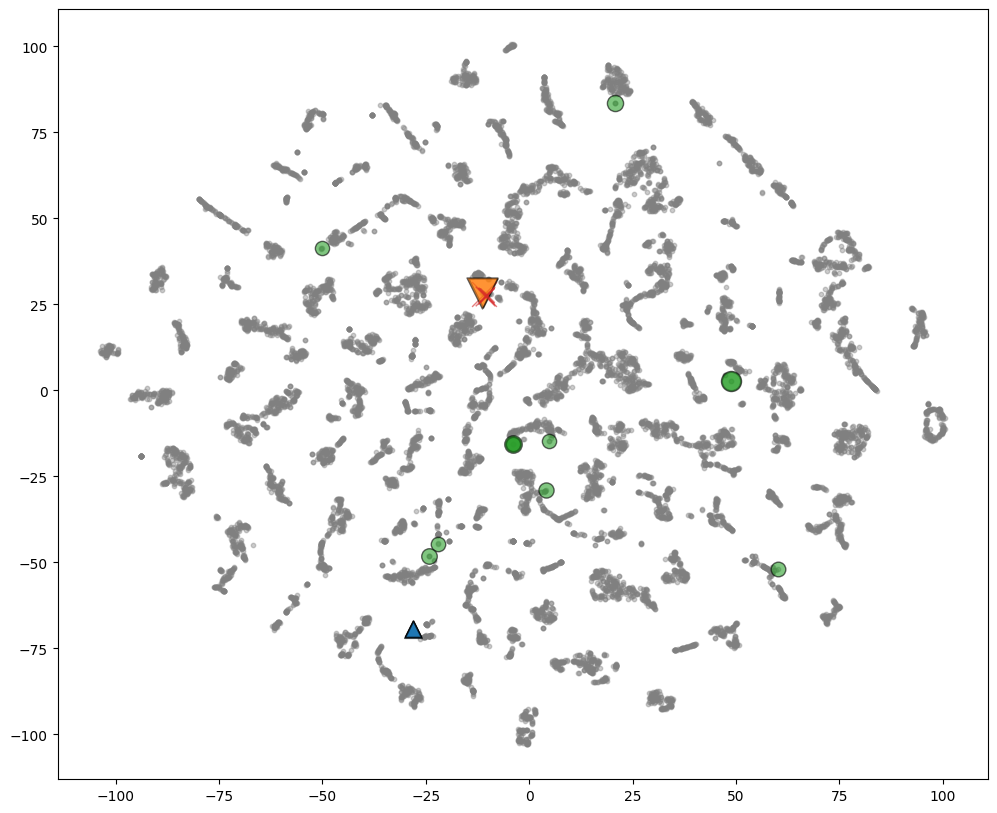

In [407]:
plt.figure(figsize=(12,10))
outlier_data=X_embedded[outlierIndex]
plt.scatter(X_embedded[:,0],X_embedded[:,1],c='grey',s=10, alpha=0.4)
for o,i in zip(outlierInfo.index, range(len(outlierInfo.index))):
    x=outlier_data[i,0]
    y=outlier_data[i,1]
    plt.scatter(x,y,c=outlierColor[i],s=outlierSize[i]*1.2,marker=outlierMarker[i], linewidths=1, edgecolors='black', alpha=0.6)